In [1]:
#import definitions
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt

In [2]:
#read in data
wego = pd.read_csv("../data/Headway Data, 8-1-2023 to 9-30-2023.csv")

In [46]:
#various explores
#preview data
#wego.head()
#wego.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350329 entries, 0 to 350328
Data columns (total 35 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   CALENDAR_ID                350329 non-null  int64  
 1   SERVICE_ABBR               350329 non-null  int64  
 2   ADHERENCE_ID               350329 non-null  int64  
 3   DATE                       350329 non-null  object 
 4   ROUTE_ABBR                 350329 non-null  int64  
 5   BLOCK_ABBR                 350329 non-null  int64  
 6   OPERATOR                   350329 non-null  int64  
 7   TRIP_ID                    350329 non-null  int64  
 8   OVERLOAD_ID                350329 non-null  int64  
 9   ROUTE_DIRECTION_NAME       350329 non-null  object 
 10  TIME_POINT_ABBR            350329 non-null  object 
 11  ROUTE_STOP_SEQUENCE        350318 non-null  float64
 12  TRIP_EDGE                  350329 non-null  int64  
 13  LATITUDE                   35

#### Cleaning & Derived Columns:

In [3]:
# Calculate HDWY Deviation Percentage
def get_dev_pct(row):
    '''Takes a row as input, returns a perfencate value. 
    Calculate the headway deviation percentage taking into
    consideration the possibility of SCHEDULED_HDWY being 0'''
    if row['SCHEDULED_HDWY'] != 0:
        return (row['HDWY_DEV']) / row['SCHEDULED_HDWY'] * 100
    else:
        return np.NaN

# create headway deviation percentage column
wego['HDWY_DEV_PCT'] = wego.apply(lambda r: get_dev_pct(r), axis=1)

In [4]:
#establish columns for gapping, bunching, and acceptable headway values
wego['HDWY_GAPPING'] = 0
wego['HDWY_ACCEPTABLE'] = 0
wego['HDWY_BUNCHING'] = 0

In [5]:
#establish functions for populating headway columns
#Note that you can calculate headway deviation percentage as HDWY_DEV/SCHEDULED_HDWY. 
#The generally accepted range of headway deviation is 50% to 150% of the scheduled headway 
#so if scheduled headway is 10 minutes, a headway deviation of up to 5 minutes would be acceptable (but not ideal).

def hdw_gapping(pct):
    if (pct > 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)
    
def hdw_acceptable(pct):
    if abs(pct) <= 50:
        return int(1)
    else:
        return int(0)
    
def hdw_bunching(pct):
    if (pct < 0) & (abs(pct) > 50):
        return int(1)
    else:
        return int(0)

In [6]:
#execute functions and apply 0/1 values to columns
wego['HDWY_BUNCHING'] = wego['HDWY_DEV_PCT'].apply(hdw_bunching)
wego['HDWY_ACCEPTABLE'] = wego['HDWY_DEV_PCT'].apply(hdw_acceptable)
wego['HDWY_GAPPING'] = wego['HDWY_DEV_PCT'].apply(hdw_gapping)

In [7]:
# #inspect new columns
#print(wego.HDWY_GAPPING.sum())
#print(wego.HDWY_ACCEPTABLE.sum())
#print(wego.HDWY_BUNCHING.sum())

In [9]:
#create a unique identifier
wego['DATE_TRIP'] = wego.apply(lambda row: str(row['CALENDAR_ID']) + '-' + str(row['TRIP_ID']), axis=1)

In [13]:
print('Number of distinct trips: ' + str(wego.DATE_TRIP.nunique()))

Number of distinct trips: 67370


#### 1. What is the overall on-time performance, and what do the overall distributions of adherence and headway deviation look like? 

In [ ]:
#overall on time performance
round(wego.ADJUSTED_ONTIME_COUNT.value_counts()[1]/len(wego)*100,2)

77.08% of trips are on time.

In [ ]:
#perfect_trips
perfect_trips = wego.groupby('DATE_TRIP')[['ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT']].sum()
perfect_trips = perfect_trips[(perfect_trips.ADJUSTED_EARLY_COUNT == 0) & (perfect_trips.ADJUSTED_LATE_COUNT == 0)]

perfect_count = len(perfect_trips)

percent_perfect = perfect_count/(wego.DATE_TRIP.nunique())*100

print('Number of perfect trips: ' + str(perfect_count))
print('Percentage of perfect trips: ' + str(percent_perfect))


In [ ]:
## Per Dibran - use adjusted fields and newly calculated hdwy to chart performance
#distribution of headway and adherence
ad_stddev = np.std(wego.ADHERENCE)
ad_mean = wego.ADHERENCE.mean()
ad_min = ad_mean-(ad_stddev*3)
ad_max = ad_mean+(ad_stddev*3)

hdw_stddev = np.std(wego.HDWY_DEV)
hdw_mean = wego.HDWY_DEV.mean()
hdw_min = hdw_mean-(hdw_stddev*3)
hdw_max = hdw_mean+(hdw_stddev*3)

In [ ]:
# wego.ADHERENCE.describe()

In [ ]:
# #distributions of adherence
# adherence_cats = wego[wego['ADJUSTED_EARLY_COUNT','ADJUSTED_ONTIME_COUNT','ADJUSTED_LATE_COUNT']].sum()
# # adherence_cats.plot(kind='hist')
# # adherence_cats.set(title='Adherence Distribution by Category', xlabel='Category',  ylabel='Count of Stops')
# sns.histplot(data=adherence_cats)

In [ ]:
#distributions of adherence deviation
adherence_hist = wego[wego['ADHERENCE'].between(ad_min, ad_max, inclusive='both')]['ADHERENCE'].plot(kind='hist', bins=50)
adherence_hist.set(title='Adherence Distribution Excluding Outliers', xlabel='Adherence',  ylabel='Count of Stops')

In [ ]:
wego.HDWY_DEV.describe()

In [ ]:
#distributions of headway deviation
adherence_hist = wego[wego['HDWY_DEV'].between(hdw_min, hdw_max, inclusive='both')]['HDWY_DEV'].plot(kind='hist', bins=50)
adherence_hist.set(title='Headway Distribution Excluding Outliers', xlabel='Headway in Minutes',  ylabel='Count of Stops')

### 2. How does direction of travel, route, or location affect the headway and on-time performance?

In [ ]:
wego.columns

#### Direction

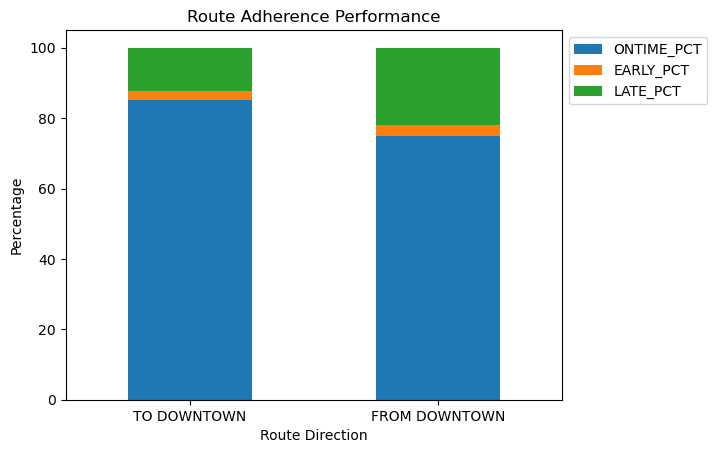

In [14]:
#ADHERENCE
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [15]:
# #initial adherence by direction using count of stops
# #headyway and adherence by route direction
# ad_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().plot(kind='bar', stacked=True)
# ad_chart.set(title='Route Direction Adherence by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# ad_chart.legend(bbox_to_anchor=(1, 1))

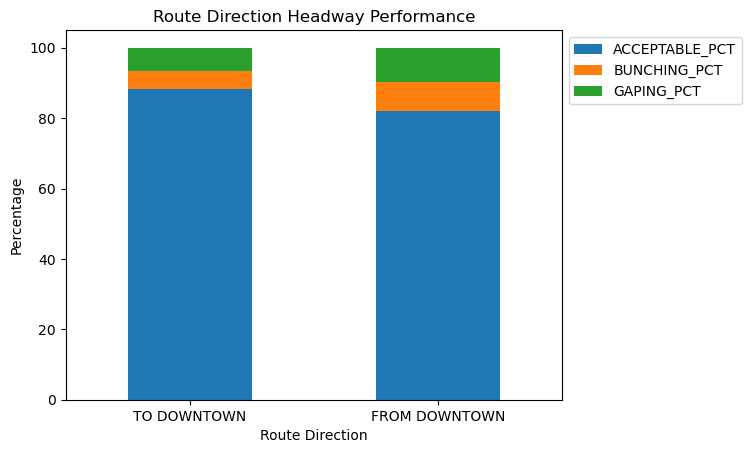

In [16]:
#HEADWAY
routes_totals = (
    wego.groupby('ROUTE_DIRECTION_NAME')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Direction Headway Performance',
        xlabel = 'Route Direction',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [17]:
# #initial headway by route direction using count of stops
# hdw_chart = wego.groupby('ROUTE_DIRECTION_NAME')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().plot(kind='bar', stacked=True)
# hdw_chart.set(title='Route Direction Headway by Category', xlabel = 'Direction', ylabel = 'Count of Stops')
# hdw_chart.legend(bbox_to_anchor=(1, 1))


In [18]:
wego.groupby('ROUTE_DIRECTION_NAME')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_DIRECTION_NAME,,
FROM DOWNTOWN,-3.960287,0.579990
TO DOWNTOWN,-2.321804,0.447773


#### Route

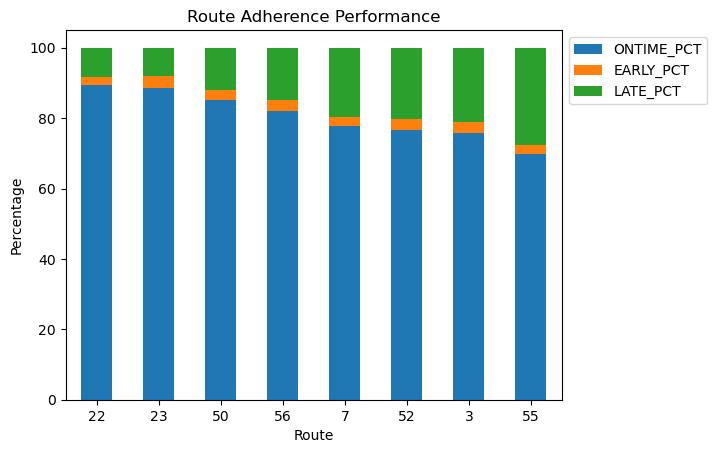

In [19]:
#break down stops by percentage of category
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ONTIME_PCT'] = routes_totals['ADJUSTED_ONTIME_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['EARLY_PCT'] = routes_totals['ADJUSTED_EARLY_COUNT'] / routes_totals['TOTALS'] * 100
routes_totals['LATE_PCT'] = routes_totals['ADJUSTED_LATE_COUNT'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('ONTIME_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Adherence Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [20]:
# #initial adherence by route ID using count of stops
# #aherence by route ID
# rte_adh_chart = wego.groupby('ROUTE_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True)
# rte_adh_chart.set(title='Adherence by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_adh_chart.legend(bbox_to_anchor=(1, 1))

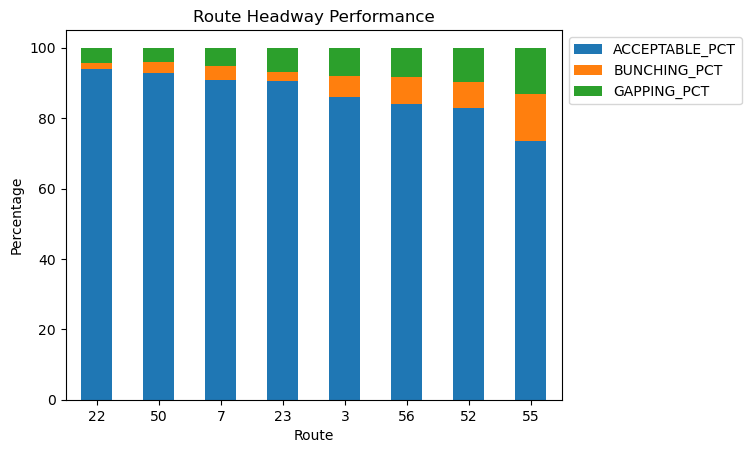

In [21]:
#break down stops by percentage of category - headway
routes_totals = (
    wego.groupby('ROUTE_ABBR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

routes_totals['TOTALS'] = routes_totals.sum(axis=1)

routes_totals['ACCEPTABLE_PCT'] = routes_totals['HDWY_ACCEPTABLE'] / routes_totals['TOTALS'] * 100
routes_totals['BUNCHING_PCT'] = routes_totals['HDWY_BUNCHING'] / routes_totals['TOTALS'] * 100
routes_totals['GAPPING_PCT'] = routes_totals['HDWY_GAPPING'] / routes_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    routes_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('ACCEPTABLE_PCT', ascending=False).plot(kind='bar', stacked=True)
ax.set(title = 'Route Headway Performance',
        xlabel = 'Route',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

In [22]:
#intitial headway by route ID using count of stops
# #headway by route ID
# rte_hdw_chart = wego.groupby('ROUTE_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True)
# rte_hdw_chart.set(title='Headway by Route', xlabel = 'Route Abbreviation', ylabel = 'Count of Stops')
# rte_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [23]:
wego.groupby('ROUTE_ABBR')[['ADHERENCE','HDWY_DEV']].mean()

,ADHERENCE,HDWY_DEV
ROUTE_ABBR,,
3,-3.761491,0.580907
7,-3.346555,0.336808
22,-1.138107,0.955867
23,-1.760110,1.053563
50,-2.505022,0.212376
52,-3.971342,0.974776
55,-4.823302,0.261038
56,-2.703988,0.149213


#### Stop location

In [24]:
wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False)

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
TIME_POINT_ABBR,,,
GXRVRGAT,11813,2355,495
DWMRT,11775,1267,237
WHBG,8868,2128,358
MCC4_18,8848,903,83
GXMADISO,8346,1169,287
...,...,...,...
CRES,28,4,0
MCC5_11,21,49,0
MCC4_13,19,3,48


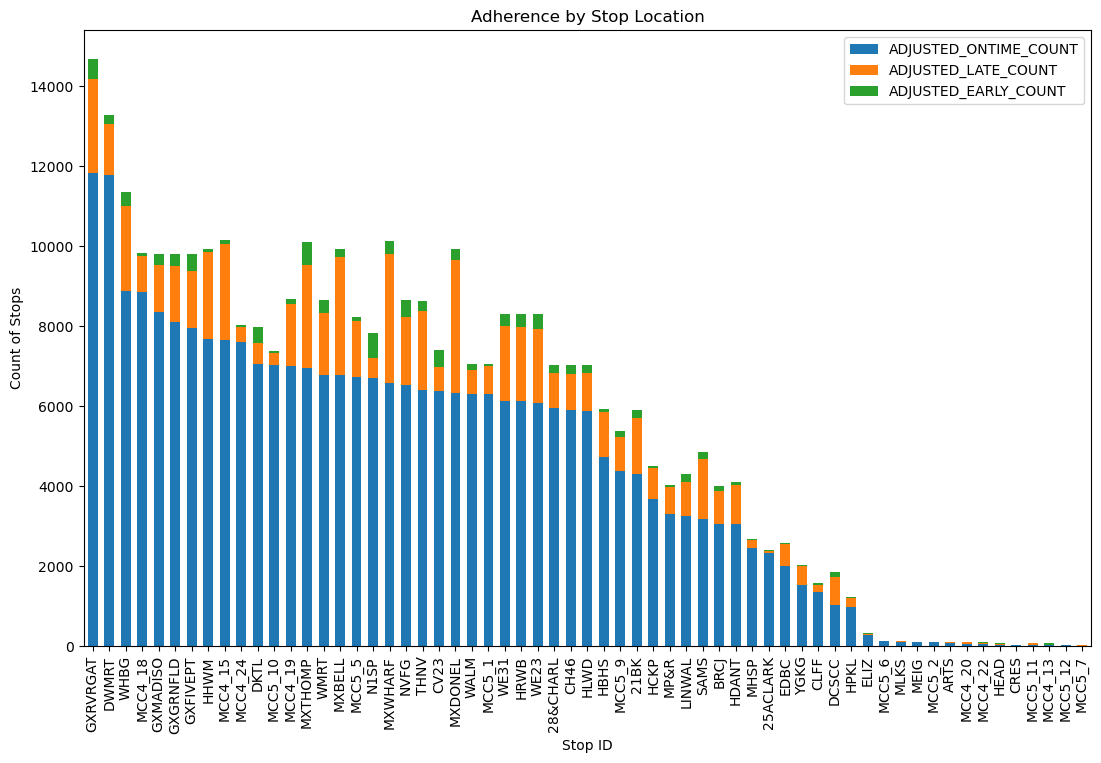

In [25]:
#adherence by stop location
#loc_adh_chart.figure(figsize=(12,12))
loc_adh_chart = wego.groupby('TIME_POINT_ABBR')[['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']].sum().sort_values('ADJUSTED_ONTIME_COUNT', ascending=False).plot(kind='bar', stacked=True, width=0.6, figsize=(13,8))
loc_adh_chart.set(title='Adherence by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
loc_adh_chart.legend(bbox_to_anchor=(1, 1))

[Text(0.5, 1.0, 'Headway by Stop Location'),
 Text(0.5, 0, 'Stop ID'),
 Text(0, 0.5, 'Count of Stops')]

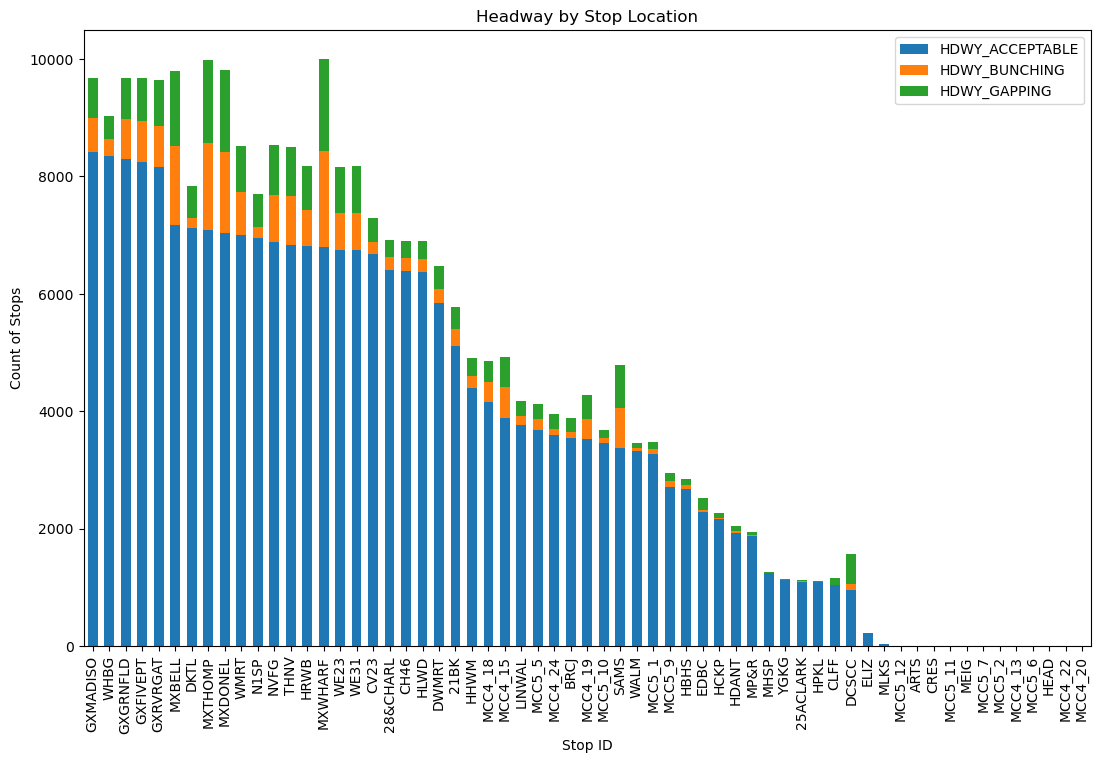

In [26]:
#use box plot
#chart with location, count, mean.
#headway by stop location
loc_hdw_chart = wego.groupby('TIME_POINT_ABBR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum().sort_values('HDWY_ACCEPTABLE', ascending=False).plot(kind='bar', stacked=True, width=0.6, figsize=(13,8))
loc_hdw_chart.set(title='Headway by Stop Location', xlabel = 'Stop ID', ylabel = 'Count of Stops')
# loc_hdw_chart.legend(bbox_to_anchor=(1, 1))

In [27]:
wego.groupby('TIME_POINT_ABBR')[['ADHERENCE','HDWY_DEV']].mean().sort_values('ADHERENCE', ascending=True)

,ADHERENCE,HDWY_DEV
TIME_POINT_ABBR,,
MCC5_11,-37.570714,NaN
MCC4_20,-13.356229,NaN
MCC5_12,-9.785042,NaN
MCC5_7,-9.075463,NaN
DCSCC,-7.091481,12.054055
...,...,...
HEAD,1.013657,NaN
MCC5_2,1.252623,NaN
25ACLARK,1.458553,0.551163


#### Q2 findings: Buses headed into downtown are more timely than outbound buses; route 22 is the most timely

### 3. How does time of day or day of week affect headway and on-time performance?

#### Time of Day

In [ ]:
wego.info(verbose=True, show_counts=True)

In [29]:
#drop rows where there's no actual departure time values
clean_dept_time = wego.dropna(subset=['ACTUAL_DEPARTURE_TIME'])

In [30]:
# Create depart time column
clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],
                                          format='mixed').dt.hour)

C:\Users\hayle\AppData\Local\Temp\ipykernel_17080\254749805.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['HOUR'] = (pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'],


In [31]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum())
hour_totals

,ADJUSTED_ONTIME_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_EARLY_COUNT
HOUR,,,
0,2898,1067,344
1,77,110,22
4,1591,16,90
5,9205,356,403
6,17110,1196,516
7,17790,3091,533
8,15816,4829,403
9,16885,2922,603
10,17172,2183,748


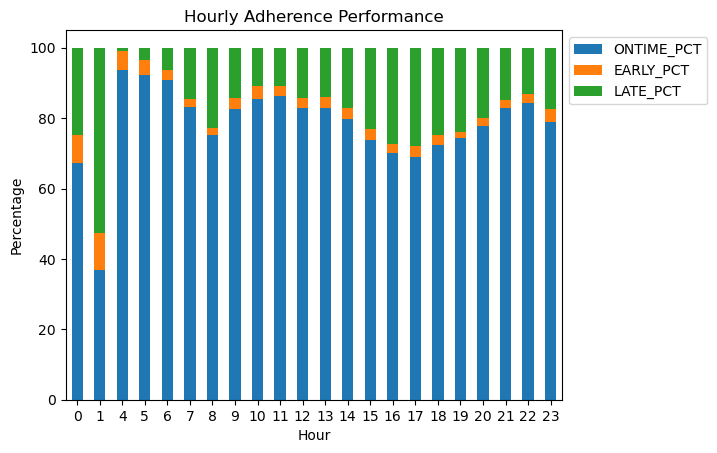

In [32]:
#ADHERENCE
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals['ONTIME_PCT'] = hour_totals['ADJUSTED_ONTIME_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals['EARLY_PCT'] = hour_totals['ADJUSTED_EARLY_COUNT'] / hour_totals['TOTALS'] * 100
hour_totals['LATE_PCT'] = hour_totals['ADJUSTED_LATE_COUNT'] / hour_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    hour_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('HOUR', ascending=True).plot(kind='bar', stacked=True)
ax.set(title = 'Hourly Adherence Performance',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

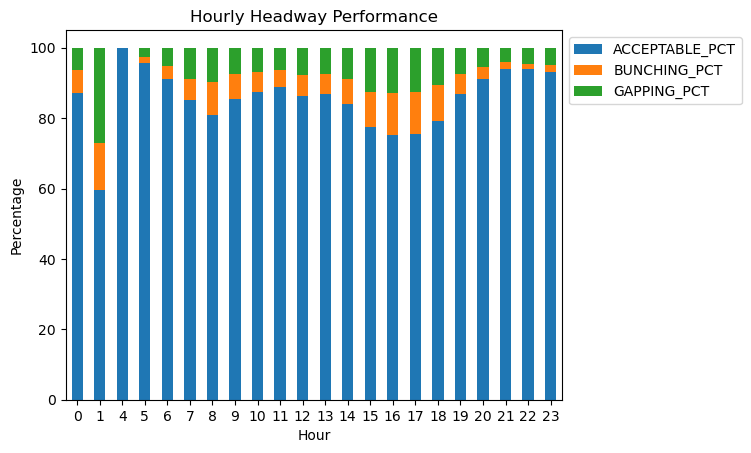

In [33]:
hour_totals = (
    clean_dept_time.groupby('HOUR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

hour_totals['TOTALS'] = hour_totals.sum(axis=1)

hour_totals['ACCEPTABLE_PCT'] = hour_totals['HDWY_ACCEPTABLE'] / hour_totals['TOTALS'] * 100
hour_totals['BUNCHING_PCT'] = hour_totals['HDWY_BUNCHING'] / hour_totals['TOTALS'] * 100
hour_totals['GAPPING_PCT'] = hour_totals['HDWY_GAPPING'] / hour_totals['TOTALS'] * 100

# Hour Headway graph
ax = (
    hour_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('HOUR', ascending=True).plot(kind='bar', stacked=True)
ax.set(title = 'Hourly Headway Performance',
        xlabel = 'Hour',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.tick_params(axis='x', rotation=0)

#### By day of week

In [35]:
clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday

C:\Users\hayle\AppData\Local\Temp\ipykernel_17080\2176059727.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['WEEKDAY'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME']).dt.weekday


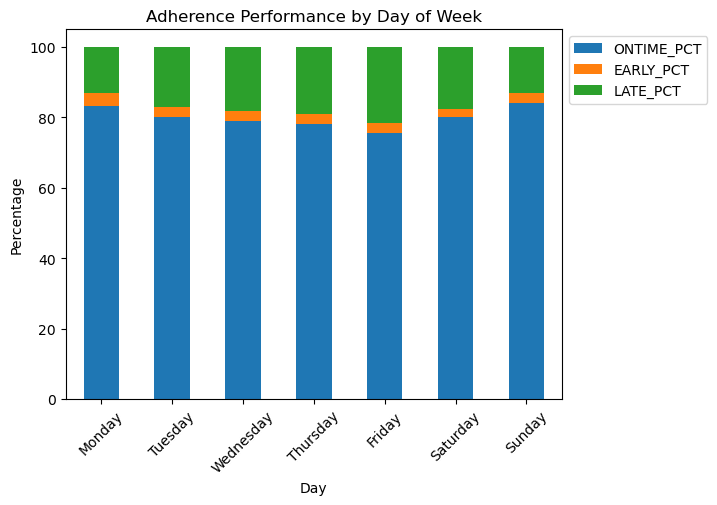

In [38]:
#ADHERENCE
day_totals = (
    clean_dept_time.groupby('WEEKDAY')
         [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
         .sum()
)

day_totals['TOTALS'] = day_totals.sum(axis=1)

day_totals['ONTIME_PCT'] = day_totals['ADJUSTED_ONTIME_COUNT'] / day_totals['TOTALS'] * 100
day_totals['EARLY_PCT'] = day_totals['ADJUSTED_EARLY_COUNT'] / day_totals['TOTALS'] * 100
day_totals['LATE_PCT'] = day_totals['ADJUSTED_LATE_COUNT'] / day_totals['TOTALS'] * 100

# Route Adherence graph
ax = (
    day_totals[['ONTIME_PCT', 'EARLY_PCT', 'LATE_PCT']]
).sort_values('WEEKDAY', ascending=True).plot(kind='bar', stacked=True)
ax.set(title = 'Adherence Performance by Day of Week',
        xlabel = 'Day',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

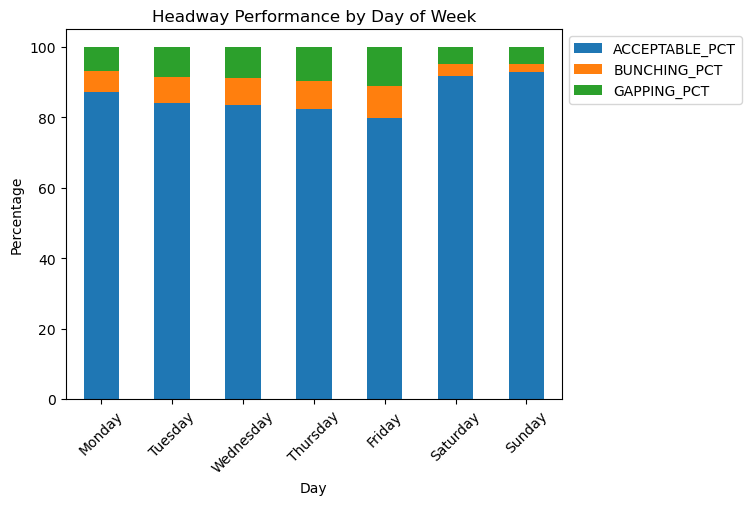

In [40]:
#HEADWAY
day_totals = (
    clean_dept_time.groupby('WEEKDAY')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']]
         .sum()
)

day_totals['TOTALS'] = day_totals.sum(axis=1)

day_totals['ACCEPTABLE_PCT'] = day_totals['HDWY_ACCEPTABLE'] / day_totals['TOTALS'] * 100
day_totals['BUNCHING_PCT'] = day_totals['HDWY_BUNCHING'] / day_totals['TOTALS'] * 100
day_totals['GAPPING_PCT'] = day_totals['HDWY_GAPPING'] / day_totals['TOTALS'] * 100

# Hour Headway graph
ax = (
    day_totals[['ACCEPTABLE_PCT', 'BUNCHING_PCT', 'GAPPING_PCT']]
).sort_values('WEEKDAY', ascending=True).plot(kind='bar', stacked=True)
ax.set(title = 'Headway Performance by Day of Week',
        xlabel = 'Day',
       ylabel = 'Percentage')
ax.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
ax.tick_params(axis='x', rotation=45)

In [41]:
clean_dept_time['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'])

C:\Users\hayle\AppData\Local\Temp\ipykernel_17080\2439592991.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_dept_time['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(clean_dept_time['ACTUAL_DEPARTURE_TIME'])


In [42]:
print(clean_dept_time['ACTUAL_DEPARTURE_TIME'].head())

0   2023-08-01 04:44:00
1   2023-08-01 04:48:00
2   2023-08-01 04:54:00
3   2023-08-01 05:03:00
4   2023-08-01 05:16:00
Name: ACTUAL_DEPARTURE_TIME, dtype: datetime64[ns]


In [45]:
hr_volume = (clean_dept_time
    .groupby(pd.Grouper(key = 'ACTUAL_DEPARTURE_TIME',     # point it to your datetime column
                     freq = '1h',               # How much do you want to group together values?
                     origin = 'epoch'           # This will start times at midnight of 1970-01-01. 
                                                # This ensures that we are starting our first grouped period on the hour
                    ))
    ['HDWY_ACCEPTABLE'].sum(),
    ['HDWY_BUNCHING'].sum(),
    ['HDWY_GAPPING'].sum()
#     .nunique() #shows only unique scooters being used during that time (if scooter is used more than once in an hour)
#     .nlargest(10)
 #.sort_values(ascending = False)
     .reset_index())
#  .head(20)

AttributeError: 'list' object has no attribute 'sum'

In [ ]:
# use Grouper to group by hour
adherence_by_time = (clean_dept_time.groupby('HOUR')
                     [['ADJUSTED_ONTIME_COUNT', 'ADJUSTED_LATE_COUNT', 'ADJUSTED_EARLY_COUNT']]
                    .sum().reset_index())
adherence_by_time

In [ ]:
# use Grouper to group by day
adherence_by_day = (clean_dept_time.groupby('WEEKDAY')
                     [['ADHERENCE', 'HDWY_DEV']]
                     .mean().reset_index())
adherence_by_day

##### 4. How much of a factor does the driver have on headway and on-time performance? The driver is indicated by the OPERATOR variable.

#### number 4 - group by operator, what percent of stops are acceptable vs total stops

#### drivers along individual routes

In [ ]:
#### number 4 - group by operator, what percent of stops are acceptable vs total stops

In [47]:
wego.OPERATOR.nunique()

341

In [56]:
wego.groupby('OPERATOR')[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum()

,HDWY_ACCEPTABLE,HDWY_BUNCHING,HDWY_GAPPING,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT
OPERATOR,,,,,,
0,0,0,0,0,0,1
56,2,0,0,0,0,3
235,7,0,2,1,5,6
244,13,3,4,0,5,20
301,16,4,10,1,17,19
...,...,...,...,...,...,...
3149,52,0,4,4,8,76
3156,220,5,5,0,71,219
3165,16,0,8,0,20,12


In [ ]:
wego.head()

In [61]:
#HEADWAY
operator_totals = (
    wego.groupby('OPERATOR')
         [['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING','ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']]
         .sum()
)

operator_totals['ADHERENCE_TOTALS'] = operator_totals[['ADJUSTED_EARLY_COUNT','ADJUSTED_LATE_COUNT','ADJUSTED_ONTIME_COUNT']].sum(axis=1)
operator_totals['HEADWAY_TOTALS'] = operator_totals[['HDWY_ACCEPTABLE','HDWY_BUNCHING','HDWY_GAPPING']].sum(axis=1)

operator_totals['ACCEPTABLE_ADHERENCE_PCT'] = operator_totals['ADJUSTED_ONTIME_COUNT'] / operator_totals['ADHERENCE_TOTALS'] * 100
operator_totals['ACCEPTABLE_HEADWAY_PCT'] = operator_totals['HDWY_ACCEPTABLE'] / operator_totals['HEADWAY_TOTALS'] * 100



,HDWY_ACCEPTABLE,HDWY_BUNCHING,HDWY_GAPPING,ADJUSTED_EARLY_COUNT,ADJUSTED_LATE_COUNT,ADJUSTED_ONTIME_COUNT,ADHERENCE_TOTALS,HEADWAY_TOTALS,ACCEPTABLE_ADHERENCE_PCT,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,,,,,,,
0,0,0,0,0,0,1,1,0,100.000000,NaN
56,2,0,0,0,0,3,3,2,100.000000,100.000000
235,7,0,2,1,5,6,12,9,50.000000,77.777778
244,13,3,4,0,5,20,25,20,80.000000,65.000000
301,16,4,10,1,17,19,37,30,51.351351,53.333333
...,...,...,...,...,...,...,...,...,...,...
3149,52,0,4,4,8,76,88,56,86.363636,92.857143
3156,220,5,5,0,71,219,290,230,75.517241,95.652174
3165,16,0,8,0,20,12,32,24,37.500000,66.666667


In [66]:
op_summary = operator_totals[['ADHERENCE_TOTALS', 'ACCEPTABLE_ADHERENCE_PCT', 'HEADWAY_TOTALS', 'ACCEPTABLE_HEADWAY_PCT']] #.sort_values('ACCEPTABLE_ADHERENCE_PCT', ascending=False)

In [67]:
op_summary.nlargest(5, 'ACCEPTABLE_ADHERENCE_PCT')

,ADHERENCE_TOTALS,ACCEPTABLE_ADHERENCE_PCT,HEADWAY_TOTALS,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,
0,1,100.000000,0,NaN
56,3,100.000000,2,100.000000
2294,45,100.000000,28,100.000000
1762,2333,98.328333,1553,91.435930
1706,44,97.727273,37,86.486486


In [71]:
op_summary.nsmallest(5, 'ACCEPTABLE_ADHERENCE_PCT')

,ADHERENCE_TOTALS,ACCEPTABLE_ADHERENCE_PCT,HEADWAY_TOTALS,ACCEPTABLE_HEADWAY_PCT
OPERATOR,,,,
473,1,0.000000,0,NaN
656,1,0.000000,1,0.000000
2982,28,7.142857,19,31.578947
1377,60,20.000000,0,NaN
2094,38,23.684211,32,46.875000


5. Is there any relationship between lateness (ADHERENCE) and headway deviation?

In [ ]:
wego['ACTUAL_DEPARTURE_TIME'] = pd.to_datetime(wego['ACTUAL_DEPARTURE_TIME'])

In [ ]:
wego["DEPART_TIME"] = wego.ACTUAL_DEPARTURE_TIME.dt.time

In [ ]:
hr_volume = (wego
    .groupby(pd.Grouper(key = 'DEPART_TIME',     # point it to your datetime column
                     freq = '1h',               # How much do you want to group together values?
                     origin = 'epoch'           # This will start times at midnight of 1970-01-01. 
                                                # This ensures that we are starting our first grouped period on the hour
                    ))
     ['ADHERENCE'].mean()
#     .nunique() #shows only unique scooters being used during that time (if scooter is used more than once in an hour)
#     .nlargest(10)
 #.sort_values(ascending = False)
     .reset_index())
#  .head(20)



**Stretch Goals:**  

6. How much impact does being late or too spaced out at the first stop have downstream?  
7. What is the impact of the layover at the start of the trip (the difference between the first stop arrival and departure time)? Does more dwell time at the beginning of a trip lead to more stable headways (lower values for % headway deviation)? Do trips with longer **scheduled** layover time have more stable headway values?  
8. What is the relationship between distance or time traveled since the start of a given trip and the headway deviation? Does headway become less stable the further along the route the bus has traveled?